Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, the UCI Machine Learning Repository has made this dataset containing actual transactions. The original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/online+retail#

This is an international dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail company. This company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

# 1. Import libraries for EDA and the dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

We import our data using *.read_csv()* method and we also add a parameter "encoding='ISO-8859-1'" as default encoding engine wasn't able to process this particular dataset.

In [2]:
# Please use the CSV file found in the zip file that this notebook is from.
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [3]:
print("There are {} entries for {} predictors.".format(df.shape[0],df.shape[1]))

There are 541909 entries for 8 predictors.


Just by looking at first 5 rows of our table we can understand the structure and datatypes present in our dataset. We can notice that we will have to deal with timeseries data, integers and floats, categorical and text data.

# 2. Exploratory data analysis

Every data science project starts with EDA as we have to understand what do we have to deal with. I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple Pandas method *.describe()* gives us a lot of useful information.

## 2.1. Quick statistical overview

In [4]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

Just a quick look at data with *.describe()* method shows us that we have negative quantities and prices, we can see that not all records have CustomerID data, we can also see that the majority of transactions are for quantites from 3 to 10 items, majority of items have price up to 5 pounds and that we have a bunch of huge outliers we will have to deal with later.

## 2.2. Dealing with types

Let's take a look with data types in our dataframe first before we make any changes.

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

If we have datetime data it's better to cast it to datetime type.

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

                     Quantity  UnitPrice  CustomerID         Country  
InvoiceDate                                                           
2010-12-01 08:26:00         6       2.55     17850.0  United Kingdom  
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom  
2010-12-01 08:26:00         8       2.75     17850.0  United Kingdom  
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom  
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom

## 2.3. Searching for and dealing with null values

Next and very important step is dealing with missing values. Normally if you encounter null values in the dataset you have to understand nature of those null values and possible impact they could have on the model. 

Let's check out what we have here.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID has too many null values so lets drop it.

In [8]:
df = df.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description

In [9]:
df[df['Description'].isnull()].head()

InvoiceNo StockCode Description  Quantity  UnitPrice  \
InvoiceDate                                                                
2010-12-01 11:52:00    536414     22139         NaN        56        0.0   
2010-12-01 14:32:00    536545     21134         NaN         1        0.0   
2010-12-01 14:33:00    536546     22145         NaN         1        0.0   
2010-12-01 14:33:00    536547     37509         NaN         1        0.0   
2010-12-01 14:34:00    536549    85226A         NaN         1        0.0   

                            Country  
InvoiceDate                          
2010-12-01 11:52:00  United Kingdom  
2010-12-01 14:32:00  United Kingdom  
2010-12-01 14:33:00  United Kingdom  
2010-12-01 14:33:00  United Kingdom  
2010-12-01 14:34:00  United Kingdom

The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales. I think, we can impute it with "UNKNOWN ITEM" at the moment.

In [10]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

## 2.4. EDA - Part 1 - Looking at columns separately

Also it makes sense to go column by column and check what pitfalls we have in our data and also to understand our numbers better. 

Let's continue checking Description column. Here we can see items that were bought most often. 

In [11]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

Here we can see our best selling products, items that appear in orders the most often. Also to make it visually more appealing let's create a bar chart for 15 top items.

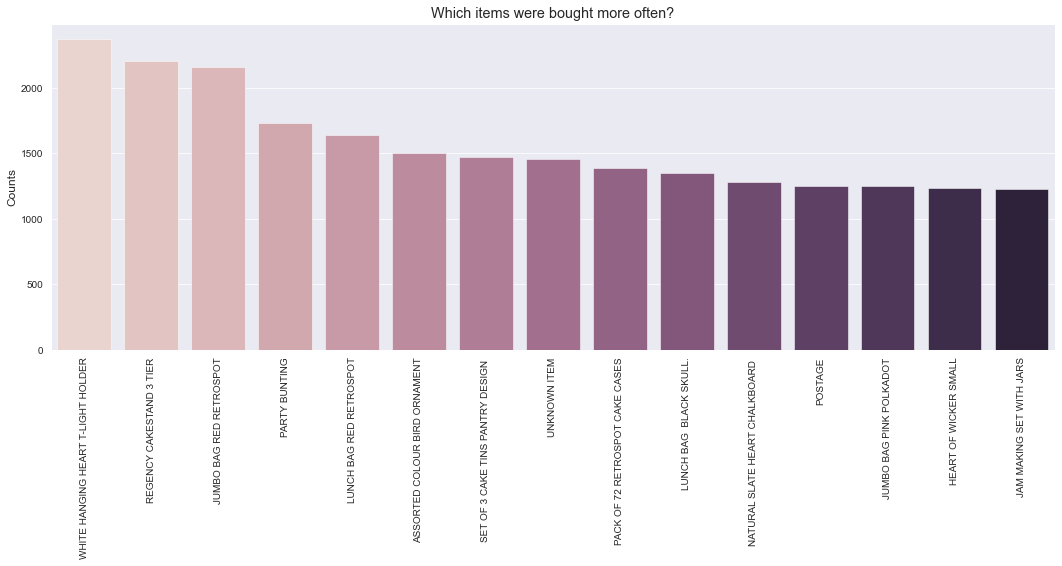

In [12]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [13]:
df['Description'].value_counts().tail()

Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: Description, dtype: int64

We also notice from above code that valid items are normally uppercased and non-valid or cancelations are in lower case

In [14]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: Description, dtype: int64

Quick check of the case of letters in Description says that there are some units with lower case letters in their name and also that lower case records are for canceled items. Here we can understand that data management in the store can be improved.

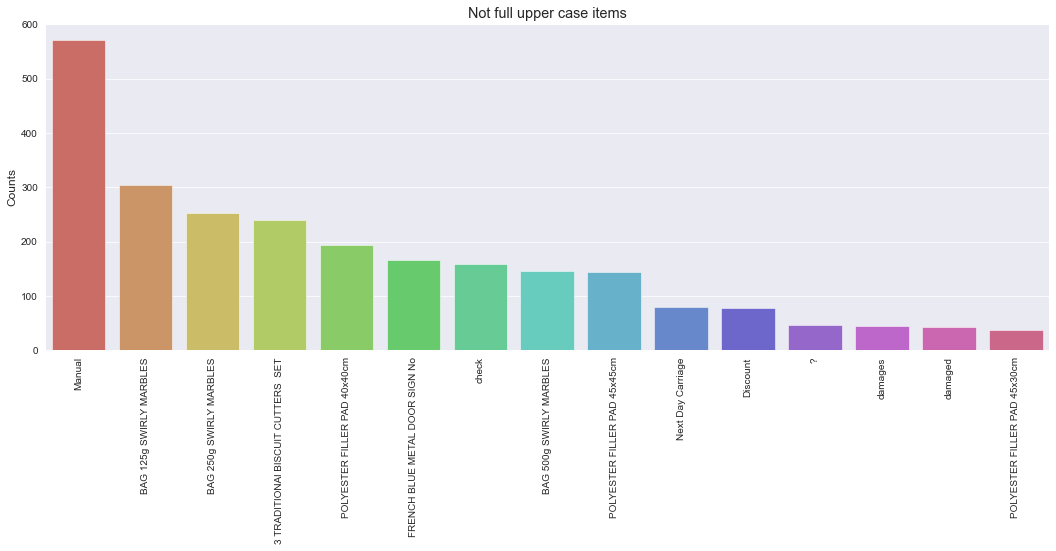

In [15]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(lcase_counts.index, lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

Also checking out stock codes, looks like they are deeply correlated with descriptions - which makes perfect sense.

In [16]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

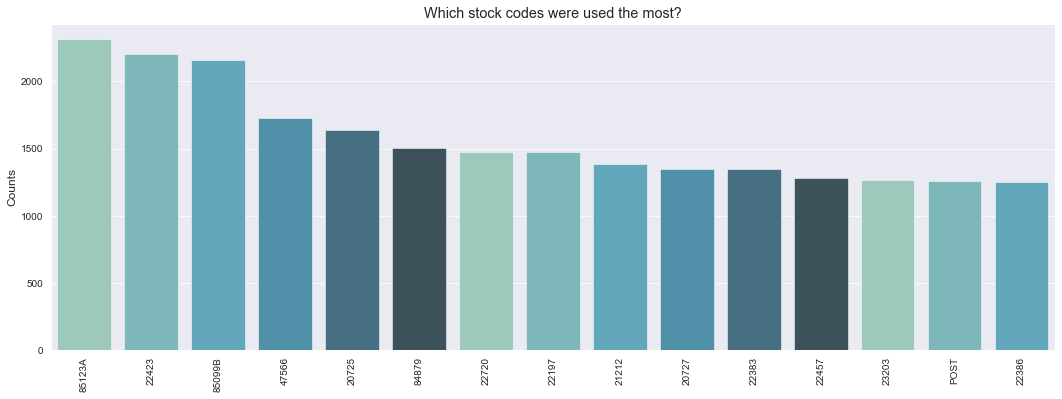

In [17]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(stock_counts.index, stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out also InvoiceNo feature.

In [18]:
df['InvoiceNo'].value_counts().tail()

554023     1
554022     1
554021     1
554020     1
C558901    1
Name: InvoiceNo, dtype: int64

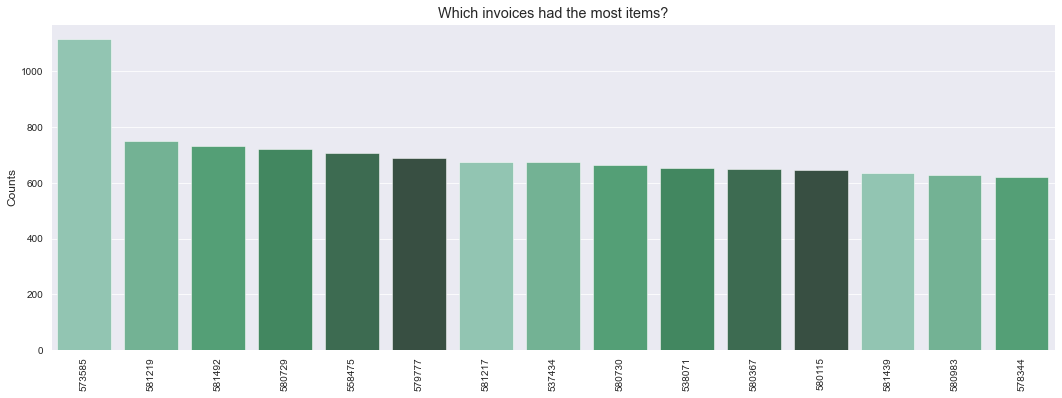

In [19]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [20]:
df[df['InvoiceNo'].str.startswith('C')].describe()

Quantity     UnitPrice
count   9288.000000   9288.000000
mean     -29.885228     48.393661
std     1145.786965    666.600430
min   -80995.000000      0.010000
25%       -6.000000      1.450000
50%       -2.000000      2.950000
75%       -1.000000      5.950000
max       -1.000000  38970.000000

Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mystery with negative quantities. 

Although, we should've gotten deeper into analysis of those returns, for the sake of simplicity let's just ignore those values for the moment and drop them.

In [21]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [22]:
df.describe()

Quantity      UnitPrice
count  532621.000000  532621.000000
mean       10.239972       3.847621
std       159.593551      41.758023
min     -9600.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   13541.330000

During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset. EDA is the series of repetitive tasks to understand better our data. And here, for example we get back to *.describe()* method to get an overall picture of our data after some manipulations. 

We still see negative quantities and negative prices, let's get into those records.



In [23]:
df[df['Quantity'] < 0].head()

InvoiceNo StockCode   Description  Quantity  UnitPrice  \
InvoiceDate                                                                  
2010-12-01 16:50:00    536589     21777  UNKNOWN ITEM       -10        0.0   
2010-12-02 14:42:00    536764    84952C  UNKNOWN ITEM       -38        0.0   
2010-12-03 15:30:00    536996     22712  UNKNOWN ITEM       -20        0.0   
2010-12-03 15:30:00    536997     22028  UNKNOWN ITEM       -20        0.0   
2010-12-03 15:30:00    536998     85067  UNKNOWN ITEM        -6        0.0   

                            Country  
InvoiceDate                          
2010-12-01 16:50:00  United Kingdom  
2010-12-02 14:42:00  United Kingdom  
2010-12-03 15:30:00  United Kingdom  
2010-12-03 15:30:00  United Kingdom  
2010-12-03 15:30:00  United Kingdom

Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items. Again, we will just ignore them for the sake of simplicity of analysis for this project and only use positive quantities.

In [24]:
df = df[df['Quantity'] > 0]
df.describe()

Quantity      UnitPrice
count  531285.000000  531285.000000
mean       10.655262       3.857296
std       156.830323      41.810047
min         1.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   13541.330000

We also see negative UnitPrice, which is not normal as well. Let's check this out.

In [25]:
df[df['UnitPrice'] < 0].describe()

Quantity  UnitPrice
count       2.0       2.00
mean        1.0  -11062.06
std         0.0       0.00
min         1.0  -11062.06
25%         1.0  -11062.06
50%         1.0  -11062.06
75%         1.0  -11062.06
max         1.0  -11062.06

In [26]:
df[df['UnitPrice'] == -11062.06]

InvoiceNo StockCode      Description  Quantity  UnitPrice  \
InvoiceDate                                                                     
2011-08-12 14:51:00   A563186         B  Adjust bad debt         1  -11062.06   
2011-08-12 14:52:00   A563187         B  Adjust bad debt         1  -11062.06   

                            Country  
InvoiceDate                          
2011-08-12 14:51:00  United Kingdom  
2011-08-12 14:52:00  United Kingdom

As there are just two rows, let's ignore them for the moment and only use entries with positive unit prices (description gives us enough warnings, although we still need some context to understand it better).

In [27]:
df = df[df['UnitPrice'] > 0]
df.describe()

Quantity      UnitPrice
count  530104.000000  530104.000000
mean       10.542037       3.907625
std       155.524124      35.915681
min         1.000000       0.001000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   13541.330000

As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model. Let's start with the most obvious one - Sales. We have quantities, we have prices - we can calculate the revenue.

In [28]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

                     Quantity  UnitPrice         Country  Sales  
InvoiceDate                                                      
2010-12-01 08:26:00         6       2.55  United Kingdom  15.30  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34  
2010-12-01 08:26:00         8       2.75  United Kingdom  22.00  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34

# 3. EDA - Part 2 - Visuals

In [29]:
fig = px.bar(x=df.Country.value_counts().index,y=df.Country.value_counts(),color = df.Country.value_counts(),log_y=True)
fig.update_layout(autosize=False, width=950, height=600, 
                  title="Invoices per country", xaxis_title="Countries",yaxis_title="No. of Invoices")
fig.show()

If you see a bar chart image above please ignore the image below. Sometimes this bar chart image doesn't show up when reopening the notebook

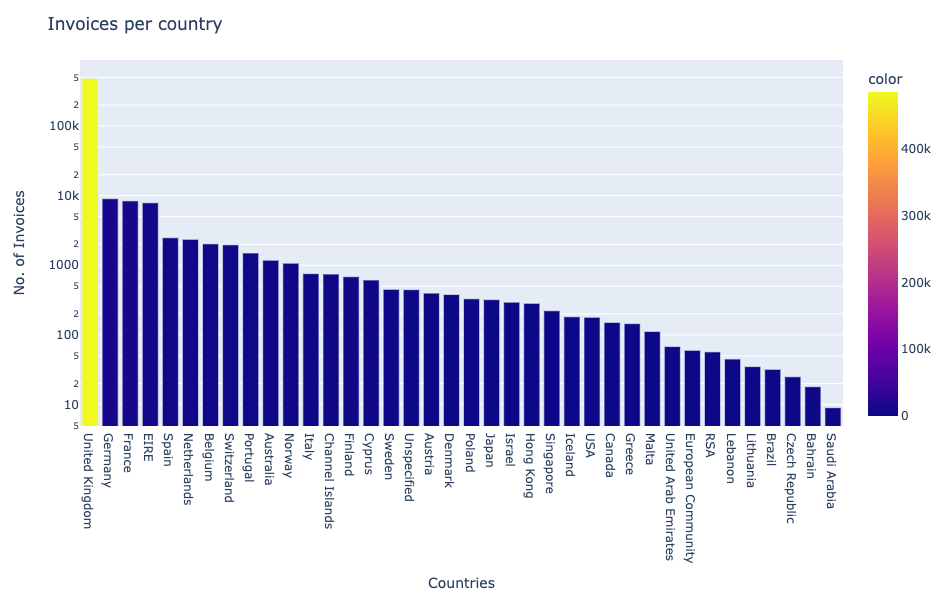

In [30]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


From above plots and calculations we can see that vast majority of sales were made in UK and just 8.49% went abroad. We can say our dataset is skewed to the UK side :D.

## 3.1. Detecting outliers

There are few different methods to detect outliers: box plots, using [IQR](https://en.wikipedia.org/wiki/Interquartile_range), scatter plot also works in some cases (and this is one of those). Also, detecting outliers using scatter plot is pretty intuitive. You plot your data and remove data points that visually are definitely out of range. Like in the chart below.

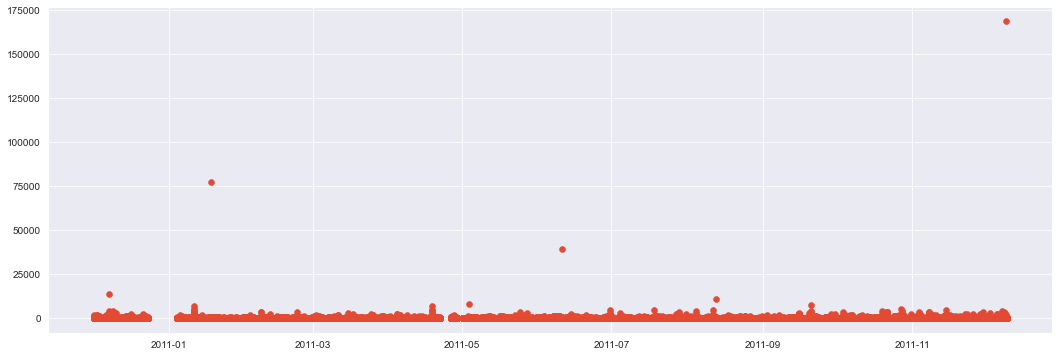

In [31]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

Let's remove obvious outliers

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

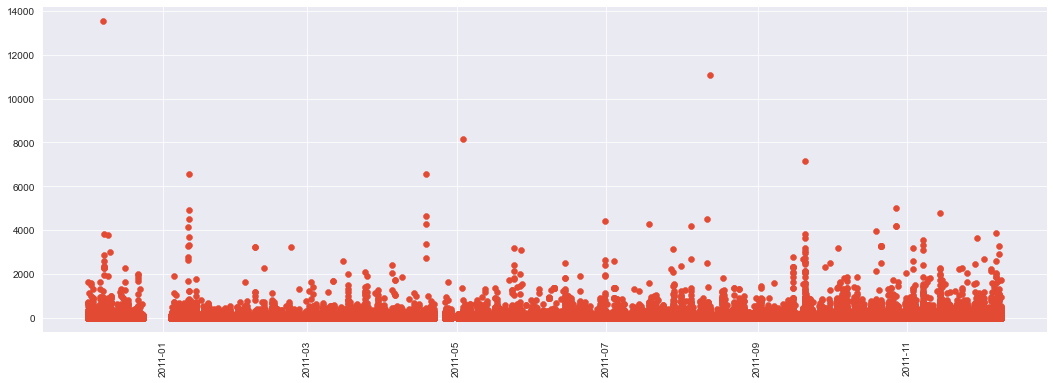

In [32]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)

After removing obvious outliers we still see some values that are out of normal distribution. To understand better the distribution of our data let's check out different percentiles of our numeric features. 

In [33]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

Quantity  UnitPrice   Sales
0.050       1.0       0.42    1.25
0.950      30.0       9.95   59.70
0.980      72.0      14.95  121.68
0.990     100.0      16.98  183.60
0.999     446.4     165.00  833.79

We can see that if we remove top 2% of our data points we will get rid of absolute outliers and will have more balaced dataset. Lets round up to 125 pounds just for simplicity sake.

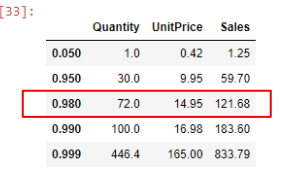

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

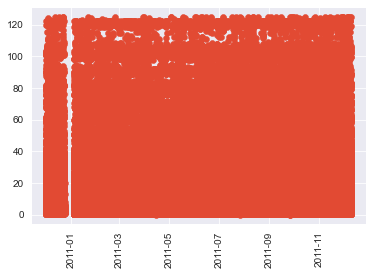

In [34]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [35]:
df_quantile.describe()

Quantity      UnitPrice          Sales
count  519958.000000  519958.000000  519958.000000
mean        7.850934       3.286582      13.850263
std        15.303867       3.949021      16.330954
min         1.000000       0.001000       0.001000
25%         1.000000       1.250000       3.750000
50%         3.000000       2.080000       9.840000
75%        10.000000       4.130000      17.220000
max      1600.000000     124.870000     124.950000

Looks like our data is almost ready for modelling. We performed a clean up, we removed outliers that were disturbing the balance of our dataset.

## 3.2. Visually checking distribution of numeric features

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

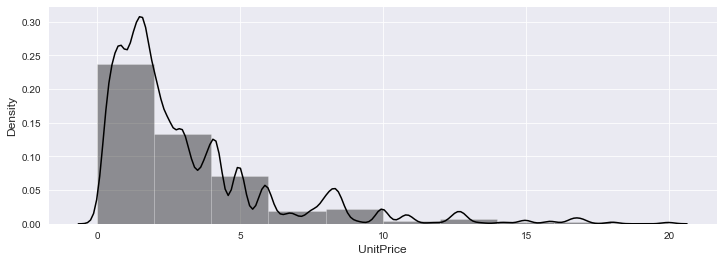

In [36]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 20]['UnitPrice'], kde=True, bins=10, color='black')

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

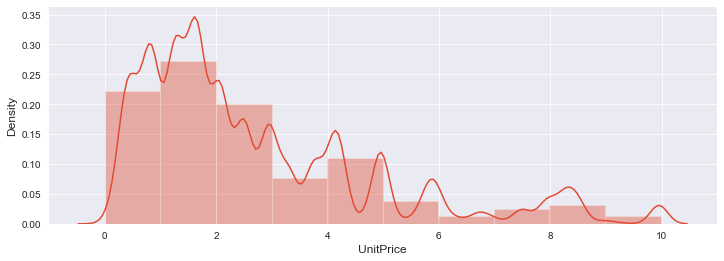

In [37]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'], kde=True, bins=10)

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

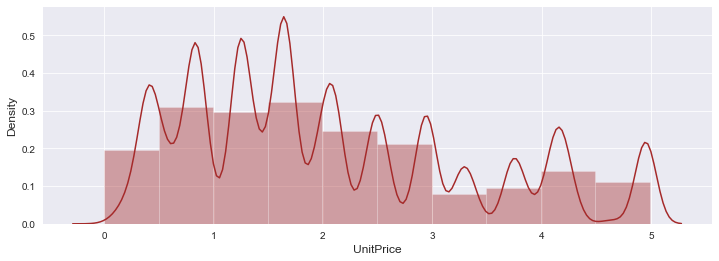

In [38]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'], kde=True, bins=10, color='brown')

From these histograms we can see that vast majority of items sold in this store has low price range - 0 to 5 pounds. 

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

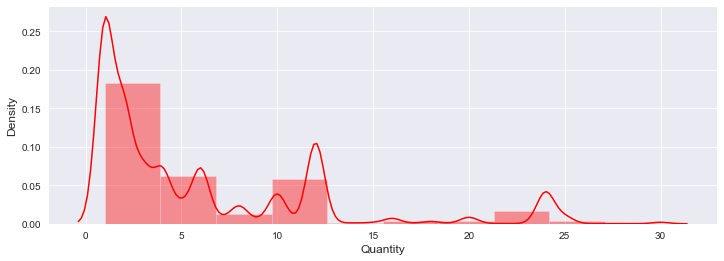

In [39]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

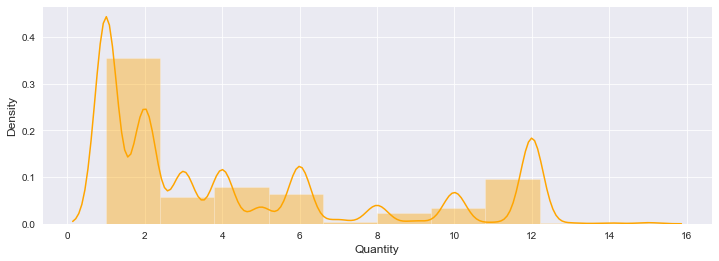

In [40]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets?

<AxesSubplot:xlabel='Sales', ylabel='Density'>

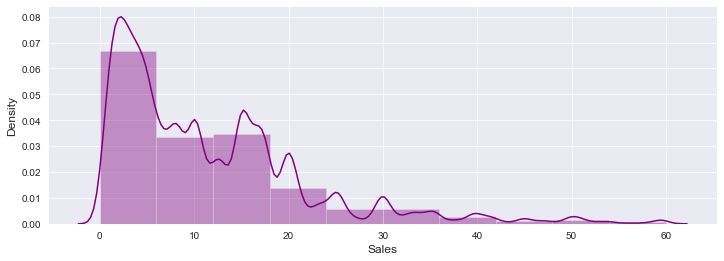

In [41]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'], kde=True, bins=10, color='purple')

<AxesSubplot:xlabel='Sales', ylabel='Density'>

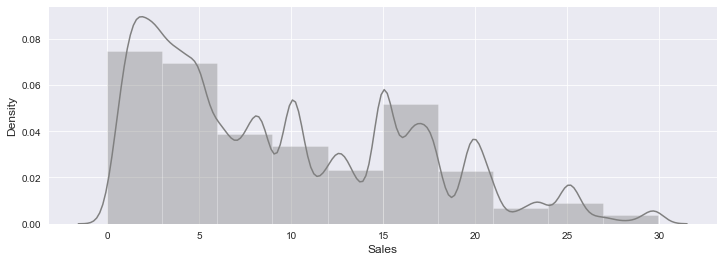

In [42]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'], kde=True, bins=10, color='grey')

From these histograms we can understand that majority of sales per order were in range 1-30 pounds each.

## 3.3. Analysing sales over time

In [43]:
df_ts = df[['Sales']]
df_ts.head()

Sales
InvoiceDate               
2010-12-01 08:26:00  15.30
2010-12-01 08:26:00  20.34
2010-12-01 08:26:00  22.00
2010-12-01 08:26:00  20.34
2010-12-01 08:26:00  20.34

As we can see every invoice has it's own timestamp (definitely based on time the order was made). We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

<AxesSubplot:xlabel='InvoiceDate'>

<Figure size 1296x432 with 0 Axes>

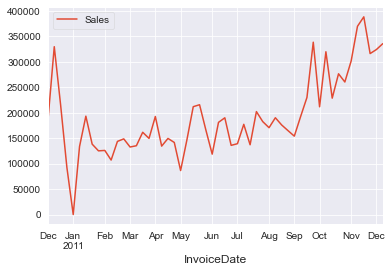

In [44]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

That week with 0 sales in January looks suspicious, let's check it closer

In [45]:
df_resample['12-2010':'01-2011']

Sales
InvoiceDate           
2010-12-05   185427.83
2010-12-12   329936.81
2010-12-19   216012.20
2010-12-26    92369.30
2011-01-02        0.00
2011-01-09   133658.19
2011-01-16   193362.04
2011-01-23   138349.58
2011-01-30   125170.79

Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders, that's why they didn't make any sales.

# 4. Preparing data for modeling and feature creation

Now it comes the most fun part of the project - building a model. To do this we will need to create few more additional features to make our model more sophisticated. Note, based on the histograms from EDA I'm only keeping records that have a unit price of under 30 pounds because that is where the majority of the sales are.

In [46]:
df_clean = df[df['UnitPrice'] < 30]
df_clean.describe()

Quantity      UnitPrice          Sales
count  528412.000000  528412.000000  528412.000000
mean       10.277348       3.220229      18.884629
std        37.850349       3.317831      64.776479
min         1.000000       0.001000       0.001000
25%         1.000000       1.250000       3.750000
50%         3.000000       2.080000       9.900000
75%        11.000000       4.130000      17.500000
max      4800.000000      29.950000    7144.720000

In [47]:
df_clean

InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...                       ...       ...                                  ...   
2011-12-09 12:50:00    581587     22613          PACK OF 20 SPACEBOY NAPKINS   
2011-12-09 12:50:00    581587     22899         CHILDREN'S APRON DOLLY GIRL    
2011-12-09 12:50:00    581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
2011-12-09 12:50:00    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
2011-12-09 12:50:00    581587     22138        BAKING SET 9 PIECE RETROSPOT    

                     Quantity  UnitPrice         Country  Sales  
InvoiceDate                                                      
2010-12-01 08:26:00         6       2.55  United Kingdom  15.30  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34  
2010-12-01 08:26:00         8       2.75  United Kingdom  22.00  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34  
2010-12-01 08:26:00         6       3.39  United Kingdom  20.34  
...                       ...        ...             ...    ...  
2011-12-09 12:50:00        12       0.85          France  10.20  
2011-12-09 12:50:00         6       2.10          France  12.60  
2011-12-09 12:50:00         4       4.15          France  16.60  
2011-12-09 12:50:00         4       4.15          France  16.60  
2011-12-09 12:50:00         3       4.95          France  14.85  

[528412 rows x 7 columns]

In [48]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=528412, freq=None)

## 4.1. Quantity per invoice & sales per Invoice features

Both quantity per invoice and sales per Invoice features could influence Sales. Note, the 'Sales per Invoice' feature could introduce more bias into our model because I used sales to create the feature but I've run out of time trying to create new features. So, currently, the model prediciton results are better with the 'Sales per Invoice' feature in this analysis but I'll have to keep mind that there might be greater bias.

In [49]:
df_join_invoice = df_clean.groupby('InvoiceNo')[['Quantity']].sum()
df_join_sales = df_clean.groupby('InvoiceNo')[['Sales']].sum()

In [50]:
df_join_invoice

Quantity
InvoiceNo          
536365           40
536366           12
536367           83
536368           15
536369            3
...             ...
581583           76
581584          120
581585          278
581586           66
581587          105

[19825 rows x 1 columns]

In [51]:
df_join_sales

Sales
InvoiceNo        
536365     139.12
536366      22.20
536367     278.73
536368      70.05
536369      17.85
...           ...
581583     124.60
581584     140.64
581585     329.05
581586     339.20
581587     249.45

[19825 rows x 1 columns]

In [52]:
df_join = df_join_sales.merge(df_join_invoice, how='inner', on='InvoiceNo')

In [53]:
df_join.head()

Sales  Quantity
InvoiceNo                  
536365     139.12        40
536366      22.20        12
536367     278.73        83
536368      70.05        15
536369      17.85         3

In [54]:
df_join = df_join.reset_index()
df_join.head()

InvoiceNo   Sales  Quantity
0    536365  139.12        40
1    536366   22.20        12
2    536367  278.73        83
3    536368   70.05        15
4    536369   17.85         3

In [55]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Sales_x': 'Sales', 
                                    'Sales_y': 'Sales_Inv', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

InvoiceNo StockCode                      Description  Quantity  \
528397    581587     22631         CIRCUS PARADE LUNCH BOX         12   
528398    581587     22556   PLASTERS IN TIN CIRCUS PARADE         12   
528399    581587     22555        PLASTERS IN TIN STRONGMAN        12   
528400    581587     22728        ALARM CLOCK BAKELIKE PINK         4   
528401    581587     22727        ALARM CLOCK BAKELIKE RED          4   
528402    581587     22726       ALARM CLOCK BAKELIKE GREEN         4   
528403    581587     22730       ALARM CLOCK BAKELIKE IVORY         4   
528404    581587     22367  CHILDRENS APRON SPACEBOY DESIGN         8   
528405    581587     22629              SPACEBOY LUNCH BOX         12   
528406    581587     23256      CHILDRENS CUTLERY SPACEBOY          4   
528407    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
528408    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
528409    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
528410    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
528411    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

        UnitPrice Country  Sales         InvoiceDate  Sales_Inv  QuantityInv  
528397       1.95  France  23.40 2011-12-09 12:50:00     249.45          105  
528398       1.65  France  19.80 2011-12-09 12:50:00     249.45          105  
528399       1.65  France  19.80 2011-12-09 12:50:00     249.45          105  
528400       3.75  France  15.00 2011-12-09 12:50:00     249.45          105  
528401       3.75  France  15.00 2011-12-09 12:50:00     249.45          105  
528402       3.75  France  15.00 2011-12-09 12:50:00     249.45          105  
528403       3.75  France  15.00 2011-12-09 12:50:00     249.45          105  
528404       1.95  France  15.60 2011-12-09 12:50:00     249.45          105  
528405       1.95  France  23.40 2011-12-09 12:50:00     249.45          105  
528406       4.15  France  16.60 2011-12-09 12:50:00     249.45          105  
528407       0.85  France  10.20 2011-12-09 12:50:00     249.45          105  
528408       2.10  France  12.60 2011-12-09 12:50:00     249.45          105  
528409       4.15  France  16.60 2011-12-09 12:50:00     249.45          105  
528410       4.15  France  16.60 2011-12-09 12:50:00     249.45          105  
528411       4.95  France  14.85 2011-12-09 12:50:00     249.45          105

In [56]:
df_clean.describe()

Quantity      UnitPrice          Sales      Sales_Inv  \
count  528412.000000  528412.000000  528412.000000  528412.000000   
mean       10.277348       3.220229      18.884629    1254.024775   
std        37.850349       3.317831      64.776479    2163.392919   
min         1.000000       0.001000       0.001000       0.380000   
25%         1.000000       1.250000       3.750000     296.760000   
50%         3.000000       2.080000       9.900000     513.990000   
75%        11.000000       4.130000      17.500000    1313.520000   
max      4800.000000      29.950000    7144.720000   52940.940000   

         QuantityInv  
count  528412.000000  
mean      538.524553  
std       891.392367  
min         1.000000  
25%       152.000000  
50%       303.000000  
75%       573.000000  
max     15049.000000

In [57]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [58]:
df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
Sales_Inv             float64
QuantityInv             int64
dtype: object

## 4.2. Binning Quantity and UnitPrice features

Based on the EDA done previously we can group these features into 6 buckets for Quantity and 5 for UnitePrice using pandas .cut() method. The logic behind using binning here (and in section 4.3) is because I'm trying to increase the efficiency and accuracy of the model by reducing the cardinality and non-linearity of the data the model uses to generate predictions.

In [59]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)]) # we're binning up to 5000 because the max quantity is 4800
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 30)]) # we're binning up to 30 because the max unit price is 29.95
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice         Country  Sales         InvoiceDate  Sales_Inv  \
0       2.55  United Kingdom  15.30 2010-12-01 08:26:00     139.12   
1       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
2       2.75  United Kingdom  22.00 2010-12-01 08:26:00     139.12   
3       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
4       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   

   QuantityInv QuantityRange PriceRange  
0           40        (5, 8]     (2, 3]  
1           40        (5, 8]     (3, 4]  
2           40        (5, 8]     (2, 3]  
3           40        (5, 8]     (3, 4]  
4           40        (5, 8]     (3, 4]

## 4.3. Extracting and Binning dates

We have noticed that different seasons have different amounts of gift sales. Sales reach their peak in the Q4, then it drastically drops in Q1 of the next year and continues to grow till its new peak in Q4 again. From this observation we can create another feature that could improve our model and lets bin these months into 4 Fiscal Quarters (Q1, Q2, Q3, Q4).

In [60]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice         Country  Sales         InvoiceDate  Sales_Inv  \
0       2.55  United Kingdom  15.30 2010-12-01 08:26:00     139.12   
1       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
2       2.75  United Kingdom  22.00 2010-12-01 08:26:00     139.12   
3       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
4       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   

   QuantityInv QuantityRange PriceRange  Month  
0           40        (5, 8]     (2, 3]     12  
1           40        (5, 8]     (3, 4]     12  
2           40        (5, 8]     (2, 3]     12  
3           40        (5, 8]     (3, 4]     12  
4           40        (5, 8]     (3, 4]     12

In [61]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

InvoiceNo StockCode                      Description  Quantity  \
528407    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
528408    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
528409    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
528410    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
528411    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

        UnitPrice Country  Sales         InvoiceDate  Sales_Inv  QuantityInv  \
528407       0.85  France  10.20 2011-12-09 12:50:00     249.45          105   
528408       2.10  France  12.60 2011-12-09 12:50:00     249.45          105   
528409       4.15  France  16.60 2011-12-09 12:50:00     249.45          105   
528410       4.15  France  16.60 2011-12-09 12:50:00     249.45          105   
528411       4.95  France  14.85 2011-12-09 12:50:00     249.45          105   

       QuantityRange PriceRange  Month DateRange  
528407      (11, 14]     (0, 1]     12   (9, 12]  
528408        (5, 8]     (2, 3]     12   (9, 12]  
528409        (2, 5]    (4, 30]     12   (9, 12]  
528410        (2, 5]    (4, 30]     12   (9, 12]  
528411        (2, 5]    (4, 30]     12   (9, 12]

# 5. Building a model

## 5.1. Splitting data into UK and non-UK

We have to separate these 2 datasets and focus on only UK orders in order to have more standardized data for our model.

In [62]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [63]:
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice         Country  Sales         InvoiceDate  Sales_Inv  \
0       2.55  United Kingdom  15.30 2010-12-01 08:26:00     139.12   
1       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
2       2.75  United Kingdom  22.00 2010-12-01 08:26:00     139.12   
3       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   
4       3.39  United Kingdom  20.34 2010-12-01 08:26:00     139.12   

   QuantityInv QuantityRange PriceRange  Month DateRange  
0           40        (5, 8]     (2, 3]     12   (9, 12]  
1           40        (5, 8]     (3, 4]     12   (9, 12]  
2           40        (5, 8]     (2, 3]     12   (9, 12]  
3           40        (5, 8]     (3, 4]     12   (9, 12]  
4           40        (5, 8]     (3, 4]     12   (9, 12]

In [64]:
df_uk.shape

(483763, 14)

## 5.2. Extracting features and creating dummy variables

In [65]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange', 'Sales_Inv']]
df_uk_model.head()

Sales  QuantityInv QuantityRange PriceRange DateRange  Sales_Inv
0  15.30           40        (5, 8]     (2, 3]   (9, 12]     139.12
1  20.34           40        (5, 8]     (3, 4]   (9, 12]     139.12
2  22.00           40        (5, 8]     (2, 3]   (9, 12]     139.12
3  20.34           40        (5, 8]     (3, 4]   (9, 12]     139.12
4  20.34           40        (5, 8]     (3, 4]   (9, 12]     139.12

In [66]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

Sales  QuantityInv  Sales_Inv  qr_(0, 2]  qr_(2, 5]  qr_(5, 8]  qr_(8, 11]  \
0  15.30           40     139.12          0          0          1           0   
1  20.34           40     139.12          0          0          1           0   
2  22.00           40     139.12          0          0          1           0   
3  20.34           40     139.12          0          0          1           0   
4  20.34           40     139.12          0          0          1           0   

   qr_(11, 14]  qr_(15, 5000]  pr_(0, 1]  pr_(1, 2]  pr_(2, 3]  pr_(3, 4]  \
0            0              0          0          0          1          0   
1            0              0          0          0          0          1   
2            0              0          0          0          1          0   
3            0              0          0          0          0          1   
4            0              0          0          0          0          1   

   pr_(4, 30]  dr_(0, 3]  dr_(3, 6]  dr_(6, 9]  dr_(9, 12]  
0           0          0          0          0           1  
1           0          0          0          0           1  
2           0          0          0          0           1  
3           0          0          0          0           1  
4           0          0          0          0           1

## 5.3. Scaling

As the majority of our features are in 0-1 range it would make sense to scale "QuantityInv" and "Sales_Inv" features too. In general, scaling these features is normally a good idea because standardization helps bring data points that are far from each other closer in order to increase effectiveness of the model.

In [67]:
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])
df_data['Sales_Inv'] = scale(df_data['Sales_Inv'])

## 5.4. Train-Test Split

Now we have to split our data into train-test data to be able to train our model and validate its capabilities.

In [68]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## 5.5. Testing and evaluating different models

Using DummyRegressor as my benchmark. So if my testing models end up performing worse than the dummy model then we should either try different models or create different features to use.

Here we use GridSearch and CrossValidation to test four types of regressors: Linear, DecisionTree, HistGradientBoosting and RandomForest. This can take a while...

In [70]:
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

# DummyRegressor
strategies= ["mean"]
param_dummy = dict(strategy=strategies)
dummy_model = DummyRegressor()

# Linear Regression
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()

# Decision Tree
min_tree_splits = range(3,4) 
min_tree_leaves = range(3,4) 
param_grid_tree = dict(min_samples_split=min_tree_splits,
                       min_samples_leaf=min_tree_leaves)
tree_model = DecisionTreeRegressor()

# Histogram-based Gradient Boosting Regression Tree
min_sample_leaves = range(4,5)
param_hgbr = dict(min_samples_leaf=min_sample_leaves)
hgbr_model = HistGradientBoostingRegressor()


# Random Forest
estimators_space = [100]
min_sample_splits = range(2,4)
min_sample_leaves = range(2,3)
param_grid_forest = dict(min_samples_split=min_sample_splits,
                        min_samples_leaf=min_sample_leaves,
                        n_estimators=estimators_space)
forest_model = RandomForestRegressor()

cv = 5

models_to_test = ['DummyRegressor','LinearRegression','DecisionTreeRegressor',
                  'HistGradientBoostingRegressor','RandomForest']
regression_dict = dict(DummyRegressor=dummy_model,
                       LinearRegression=linear_model,
                       DecisionTreeRegressor=tree_model,
                       HistGradientBoostingRegressor=hgbr_model,
                       RandomForest=forest_model)
param_grid_dict = dict(DummyRegressor=param_dummy,
                       LinearRegression=param_grid_linear,
                       DecisionTreeRegressor=param_grid_tree,
                       HistGradientBoostingRegressor=param_hgbr,
                       RandomForest=param_grid_forest)

score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}


for model in models_to_test:
  regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  # Print the tuned parameters and score
  print(" === Start report for regressor {} ===".format(model))
  score_dict[model] = regressor.best_score_
  print("Tuned Parameters: {}".format(regressor.best_params_))
      # Parameter setting that gave the best results on the hold out data
  params_dict = regressor.best_params_
  print("Best score is {:.4f}".format(regressor.best_score_)) 
      # Best score: The Mean cross-validated score of the best_estimator

  # Compute metrics
  mae_dict[model] = mean_absolute_error(y_test, y_pred)
  print("MAE for {}".format(model))
  print("%.4f" %mean_absolute_error(y_test, y_pred))
  mse_dict[model] = mean_squared_error(y_test, y_pred)
  print("MSE for {}".format(model))
  print("%.4f" %mean_squared_error(y_test, y_pred))
  r2_dict[model] = r2_score(y_test, y_pred)
  print("R2 score for {}".format(model))
  print("%.4f" %r2_score(y_test, y_pred))
  print(" === End of report for regressor {} === \n".format(model))
  

 === Start report for regressor DummyRegressor ===
Tuned Parameters: {'strategy': 'mean'}
Best score is -0.0000
MAE for DummyRegressor
15.6572
MSE for DummyRegressor
3440.7579
R2 score for DummyRegressor
-0.0000
 === End of report for regressor DummyRegressor === 

 === Start report for regressor LinearRegression ===
Tuned Parameters: {'fit_intercept': False}
Best score is 0.1733
MAE for LinearRegression
15.3629
MSE for LinearRegression
2833.6140
R2 score for LinearRegression
0.1764
 === End of report for regressor LinearRegression === 

 === Start report for regressor DecisionTreeRegressor ===
Tuned Parameters: {'min_samples_leaf': 3, 'min_samples_split': 3}
Best score is 0.4694
MAE for DecisionTreeRegressor
6.3892
MSE for DecisionTreeRegressor
1373.5164
R2 score for DecisionTreeRegressor
0.6008
 === End of report for regressor DecisionTreeRegressor === 

 === Start report for regressor HistGradientBoostingRegressor ===
Tuned Parameters: {'min_samples_leaf': 4}
Best score is 0.5185
MA

<AxesSubplot:title={'center':'Regressor Model Comparison - MAE'}, xlabel='Best MAE Score', ylabel='Regressor Model'>

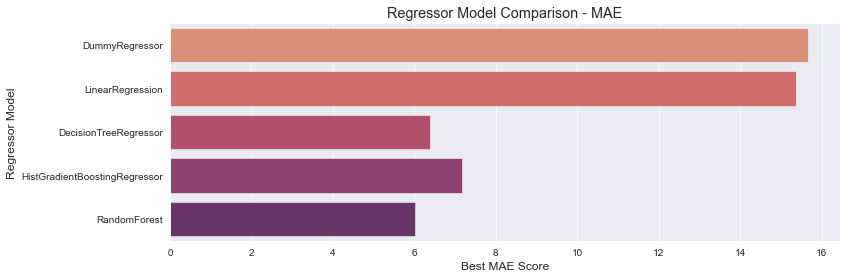

In [71]:
# Creating summary report for MAE
summary_cols = ['Best MAE Score']
summary = pd.DataFrame.from_dict(mae_dict, orient='index')
summary.index.name = 'Regressor Model'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizing results
plt.figure(figsize=(12,4))
plt.title('Regressor Model Comparison - MAE')

sns.barplot(x='Best MAE Score', y='Regressor Model', data=summary, palette = 'flare')

The lower the MAE score the better.

<AxesSubplot:title={'center':'Regressor Model Comparison - MSE'}, xlabel='Best MSE Score', ylabel='Regressor Model'>

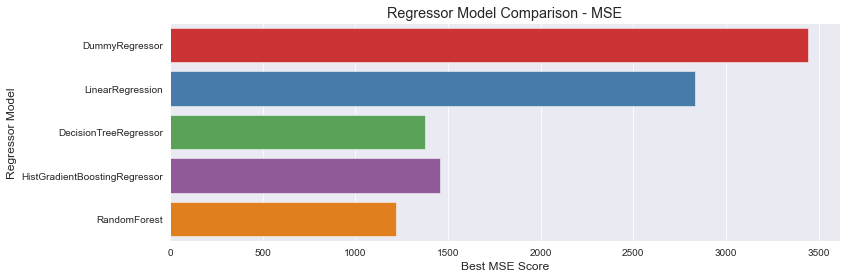

In [72]:
# Creating summary report for MSE
summary_cols = ['Best MSE Score']
summary = pd.DataFrame.from_dict(mse_dict, orient='index')
summary.index.name = 'Regressor Model'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizing results
plt.figure(figsize=(12,4))
plt.title('Regressor Model Comparison - MSE')

sns.barplot(x='Best MSE Score', y='Regressor Model', data=summary, palette = 'Set1')

The lower the MSE score the better.

<AxesSubplot:title={'center':'Regressor Model Comparison - R2'}, xlabel='Best R2 Score', ylabel='Regressor Model'>

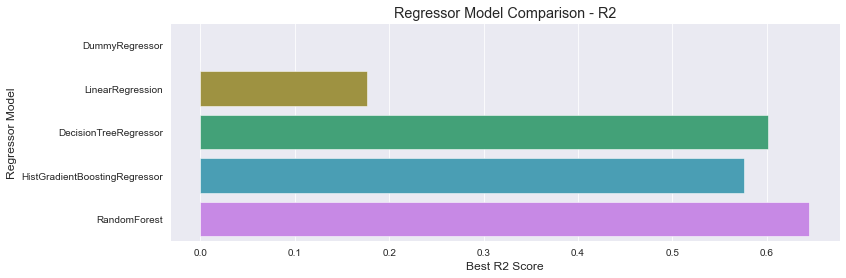

In [73]:
# Creating summary report for R2
summary_cols = ['Best R2 Score']
summary = pd.DataFrame.from_dict(r2_dict, orient='index')
summary.index.name = 'Regressor Model'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizing results
plt.figure(figsize=(12,4))
plt.title('Regressor Model Comparison - R2')

sns.barplot(x='Best R2 Score', y='Regressor Model', data=summary, palette = 'husl')

The higher the R2 score the better.

# Conclusions


This is a basic analysis of a transactions dataset with a model that predicts sales. Still a lot of things can be improved:


*   Perform cluster analysis on descriptions and create features based on it
*   Make a deeper split of dates
*   Create features using stock numbers
*   Compare domestic and abroad sales
*   Try deep learning models
*   Experiment with tuning the hyperparameters of our models to achieve better results

Random Forest Regressor appears to be the best model from our basic analysis with the lowest MAE score, lowest MSE score and the highest R2 score of more than 0.6. However, these results indicate that the model prediciton performance is mediocre and improvements (the ones mentioned above) need to be implemented before we see better outcomes.

